In [1]:
%matplotlib inline
import os 
import sys
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/Oct_4'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'

measures = ['SNR_MAG', 'CNR_MAG','FBER_MAG',
            'EFC_MAG', 'QI1_MAG',  'FWHM_MAG']

drop_c = ['WSKT','SC1T','LL5T', 'GSAT'] 
# WSKT,SC1T,LL5T Young Females scanned extra for MRS review. 
# GSAT removed since HSPP female removed 
drop_p = ['AA8P', 'RA9P', 'STDP','NL2P','HSPP', 'DF2P'] 
# AA8P motion outliers via mehalonobis distance for Quality metrics 
# rest– mehalonobis distance for SN,STN,Puta

In [2]:
def get_all_dfs(img, population, study_id, trt=False):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_a.csv'%(population)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]    
    def get_mrs(vox):
        if trt == False:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%(vox, population, study_id)),index_col = 0)
        elif trt == True:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%(vox, population, study_id)),index_col = 0)
        df['Gln_Glu'] = df['Gln'] / df['Glu']
        df.columns = ['%s_'%vox + str(col) for col in df.columns]
        return df
    df = pd.concat([QSM, get_mrs('STR'), CLN], axis=1, join_axes=[QSM.index])
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
controls_b = get_all_dfs('QSM', 'controls', 'b', trt=True)#.drop(drop_c, axis = 0) 
patients_b = get_all_dfs('QSM', 'patients', 'b', trt=True)#.drop(drop_p, axis = 0) 

controls_b.index = controls_b.index + 'b'
patients_b.index = patients_b.index + 'b'

DF_ALL =pd.concat([controls_a, patients_a], axis=0)

In [3]:
def get_higher_outlier(df, measure):
    print measure
    df = df[measure]
    cut =  np.mean(df) + 2*np.std(df)
    print 'mean=',np.mean(df), 'cut=',cut
    for s,v in zip(df.index,df):    
        if v > cut:
            print s,v
get_higher_outlier(DF_ALL, 'EFC_MAG')
get_higher_outlier(DF_ALL, 'FWHM_MAG')
get_higher_outlier(DF_ALL, 'QI1_MAG')
get_higher_outlier(DF_ALL, 'SNR_MAG')
get_higher_outlier(DF_ALL, 'CNR_MAG')

EFC_MAG
mean= 0.457365806695 cut= 0.580606084494
HM2X 0.5867053866
FWHM_MAG
mean= 2.11929568182 cut= 2.42958162684
QI1_MAG
mean= 0.0864361963 cut= 0.182764103935
LA9P 0.1913833066
SNR_MAG
mean= -0.0175075741568 cut= 0.861184790431
CNR_MAG
mean= 0.200454867543 cut= 0.50396349455
BE9P 0.5438496682
CF1P 0.530642656


In [4]:
def grubbs_outliers(df, measure, alpha = 0.95):
    from outliers import smirnov_grubbs as grubbs
    out =  [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 
    print measure, out
    #return out

def get_higher_outlier(df, measure):
    print measure
    df = df[measure]
    cut =  np.mean(df) + 2*np.std(df)
    print 'mean=',np.mean(df), 'cut=',cut
    for s,v in zip(df.index,df):    
        if v > cut:
            print s,v
get_higher_outlier(DF_ALL, 'EFC_MAG')
get_higher_outlier(DF_ALL, 'FWHM_MAG')
get_higher_outlier(DF_ALL, 'QI1_MAG')
get_higher_outlier(DF_ALL, 'SNR_MAG')
get_higher_outlier(DF_ALL, 'CNR_MAG')
get_higher_outlier(DF_ALL, 'FBER_MAG')

EFC_MAG
mean= 0.457365806695 cut= 0.580606084494
HM2X 0.5867053866
FWHM_MAG
mean= 2.11929568182 cut= 2.42958162684
QI1_MAG
mean= 0.0864361963 cut= 0.182764103935
LA9P 0.1913833066
SNR_MAG
mean= -0.0175075741568 cut= 0.861184790431
CNR_MAG
mean= 0.200454867543 cut= 0.50396349455
BE9P 0.5438496682
CF1P 0.530642656
FBER_MAG
mean= 2.19495372493 cut= 3.9219911933
CF1P 4.0936342016


In [5]:
def gESD_outliers(df, measure, maxOLs =5, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(DF_ALL[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    out   = [df.index[i] for i in index]
    print measure, out 

In [6]:
for i in measures:
    gESD_outliers(DF_ALL, str(i))

SNR_MAG []
CNR_MAG []
FBER_MAG []
EFC_MAG []
QI1_MAG []
FWHM_MAG []


In [7]:
def cohen_d(df1,df2, metabolite):
    x = df1[metabolite].dropna(axis=0)
    y = df2[metabolite].dropna(axis=0)
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

def grubbs_outliers(df, measure, alpha = 0.05):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 
def calc_confidence_95(df1,df2, metabolite):
    import numpy as np, statsmodels.stats.api as sms
    X1 = df1[metabolite].dropna(axis=0)
    X2 = df2[metabolite].dropna(axis=0)
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    return cm.tconfint_diff(usevar='pooled')
    
def make_statistical_comparison(df_controls, df_patients, stat, measures = measures, grubbs = False, ESD = False):
    df_controls['Population'] = 0
    df_patients['Population'] = 1
    cols = ['N','Controls', 'Patients','Levene','KS', 'KS_C', 'KS_P','D','CI_95', 'Statistic', 'p_val', 'p_fdr', 'sig']
    dfs = pd.DataFrame(index= cols, columns=measures)
    
    if grubbs:
        for measure in measures:
            grubbs_controls = grubbs_outliers(df_controls, measure)
            grubbs_patients = grubbs_outliers(df_patients, measure)
            print 'GRUBBS OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
    elif ESD:
        for measure in measures:
            grubbs_controls = gESD_outliers(df_controls, measure)
            grubbs_patients = gESD_outliers(df_patients, measure)
            print 'gESD OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
        
    df = pd.concat([df_controls, df_patients])
    for measure in measures:
        if stat == 'MR':
            formula = '%s ~ Population + Age + Gender'%measure
            model   = smf.ols(formula=formula, data = df)
            fit     = model.fit()
            p_val   = np.round(fit.pvalues[1],5)
            t_val   = np.round(fit.tvalues[1],3)
        
        elif stat == 'MW':
            
            t_val, p_val = mannwhitneyu(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        elif stat == 'TT':
            t_val, p_val = ttest_ind(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        ci95 = calc_confidence_95(df_controls, df_patients, measure)
            
        xval = 1#00
        npr  = 2
        dfs.ix['N'][measure] = len(df_controls[measure].dropna()), len(df_patients[measure].dropna())
        dfs.ix['Levene'][measure] = np.round(levene(df_controls[measure].dropna(), df_patients[measure].dropna())[1],2)
        dfs.ix['KS'][measure] = np.round(ks_2samp(preprocessing.scale(df_controls[measure].dropna()), 
                                                  preprocessing.scale(df_patients[measure].dropna()))[1], 2)
        dfs.ix['KS_C'][measure] = np.round(kstest(preprocessing.scale(df_controls[measure].dropna()), 'norm')[1],2)
        dfs.ix['KS_P'][measure] = np.round(kstest(preprocessing.scale(df_patients[measure].dropna()), 'norm')[1],2)
        dfs.ix['D'][measure]    = cohen_d(df_controls, df_patients,measure)
        dfs.ix['Controls'][measure] = '%s±%s'%(xval*np.round(np.mean(df_controls[measure]),npr), 
                                              xval*np.round(np.std(df_controls[measure]), npr))   
        dfs.ix['Patients'][measure] = '%s±%s'%(xval*np.round(np.mean(df_patients[measure]),npr), 
                                              xval*np.round(np.std(df_patients[measure]), npr))   
        dfs.ix['D'][measure]    = np.round(cohen_d(df_controls, df_patients,measure),2)
        dfs.ix['CI_95'][measure]= '%s to %s'%(np.round(ci95[0],2), np.round(ci95[1],2))
        dfs.ix['Statistic'][measure]= np.round(t_val,2)        
        dfs.ix['p_val'][measure]    = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
    
    dfs = dfs.T#.sort('p_val')
    dfs['p_fdr'] = fdrcorrection0(dfs.p_val)[1]
    dfs['sig'] = fdrcorrection0(dfs.p_val)[0]
    return dfs, df 

In [8]:
X, XX = make_statistical_comparison(controls_a, patients_a, 'MW')
X

,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
SNR_MAG,"(22, 22)",-0.03±0.47,-0.0±0.41,0.27,0.98,0.49,0.8,-0.07,-0.31 to 0.24,229,0.38461,0.38461,False
CNR_MAG,"(22, 22)",0.18±0.14,0.22±0.16,0.53,0.98,0.97,0.65,-0.28,-0.14 to 0.05,209,0.22277,0.339144,False
FBER_MAG,"(22, 22)",2.25±0.84,2.14±0.88,0.81,0.98,0.54,0.56,0.13,-0.42 to 0.65,215,0.26696,0.339144,False
EFC_MAG,"(22, 22)",0.45±0.07,0.46±0.05,0.24,0.98,0.37,0.64,-0.08,-0.04 to 0.03,217,0.28262,0.339144,False
QI1_MAG,"(22, 22)",0.08±0.05,0.1±0.05,0.52,0.82,0.85,0.49,-0.38,-0.05 to 0.01,200,0.165,0.339144,False
FWHM_MAG,"(22, 22)",2.1±0.13,2.13±0.18,0.15,0.98,0.67,0.85,-0.19,-0.13 to 0.07,211,0.23702,0.339144,False


In [166]:
def make_plot(df1,df2, m1 = 'STN', m2 = 'SN', m3 = 'RN', pal= [0,3]):
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
    f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
    f.set_size_inches([20,10])
    pallete = sns.color_palette("hls", 10)[pal[0]:pal[1]]
    x = 1000
                
    def make_multiplot(m,  pallete, ax, jitter = 0.2, font=30):   
        data = [df1[m]*x, df2[m]*x] 
        g = sns.violinplot( data = data, color = pallete, ax = ax,whis= 1)
        g = sns.stripplot(data=data, color = pallete, jitter= jitter, ax = ax, size = 10, linewidth=1)
        g = sns.pointplot(data=data, color = pallete, linestyles=['--'], markers=['o'], ax =ax)
        g.legend([m], fontsize = 30 , handlelength=0, loc = 2)
        g.set(xticklabels=['Controls','Patients'])      
        def annot_datapoints(df, m, xr, alpha = 0.2, ax = ax):
            for i,s in zip(df[m]* x, df.index):
                ann = ax.annotate('%s'%s, xy= (xr,i), size= 15, color='b', alpha = alpha)
        
        annot_datapoints(df1,m, -0.4)
        annot_datapoints(df2,m, 0.4)
    
    make_multiplot(m1,  pallete[0], ax1)
    make_multiplot(m2, pallete[1], ax2)
    make_multiplot(m3, pallete[2], ax3)

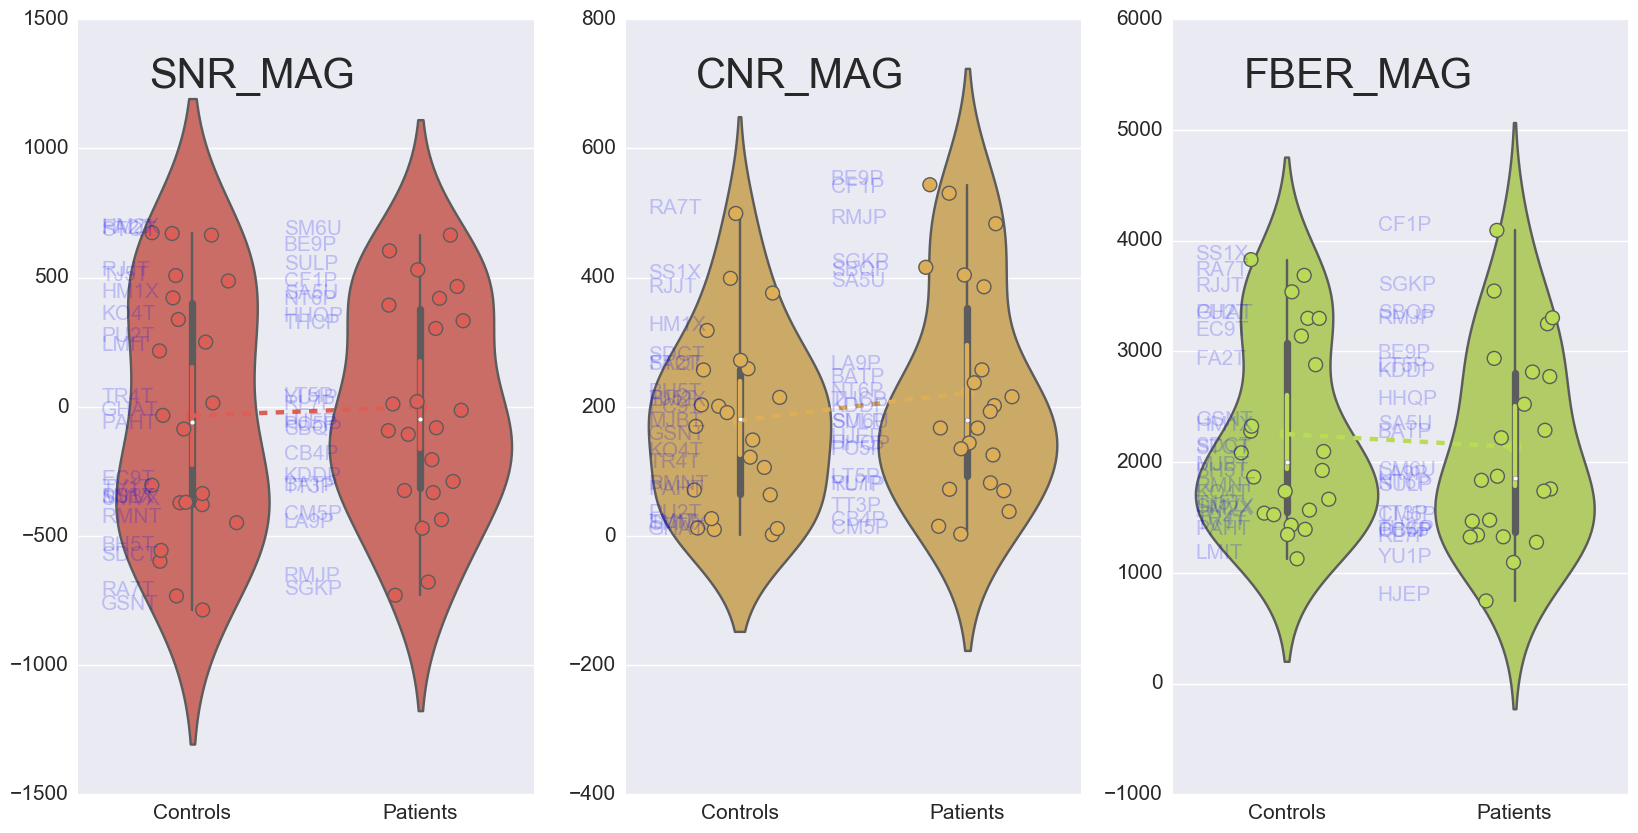

In [167]:
make_plot(controls_a,patients_a, m1 = 'SNR_MAG', m2 = 'CNR_MAG', m3 = 'FBER_MAG', pal= [0,3])

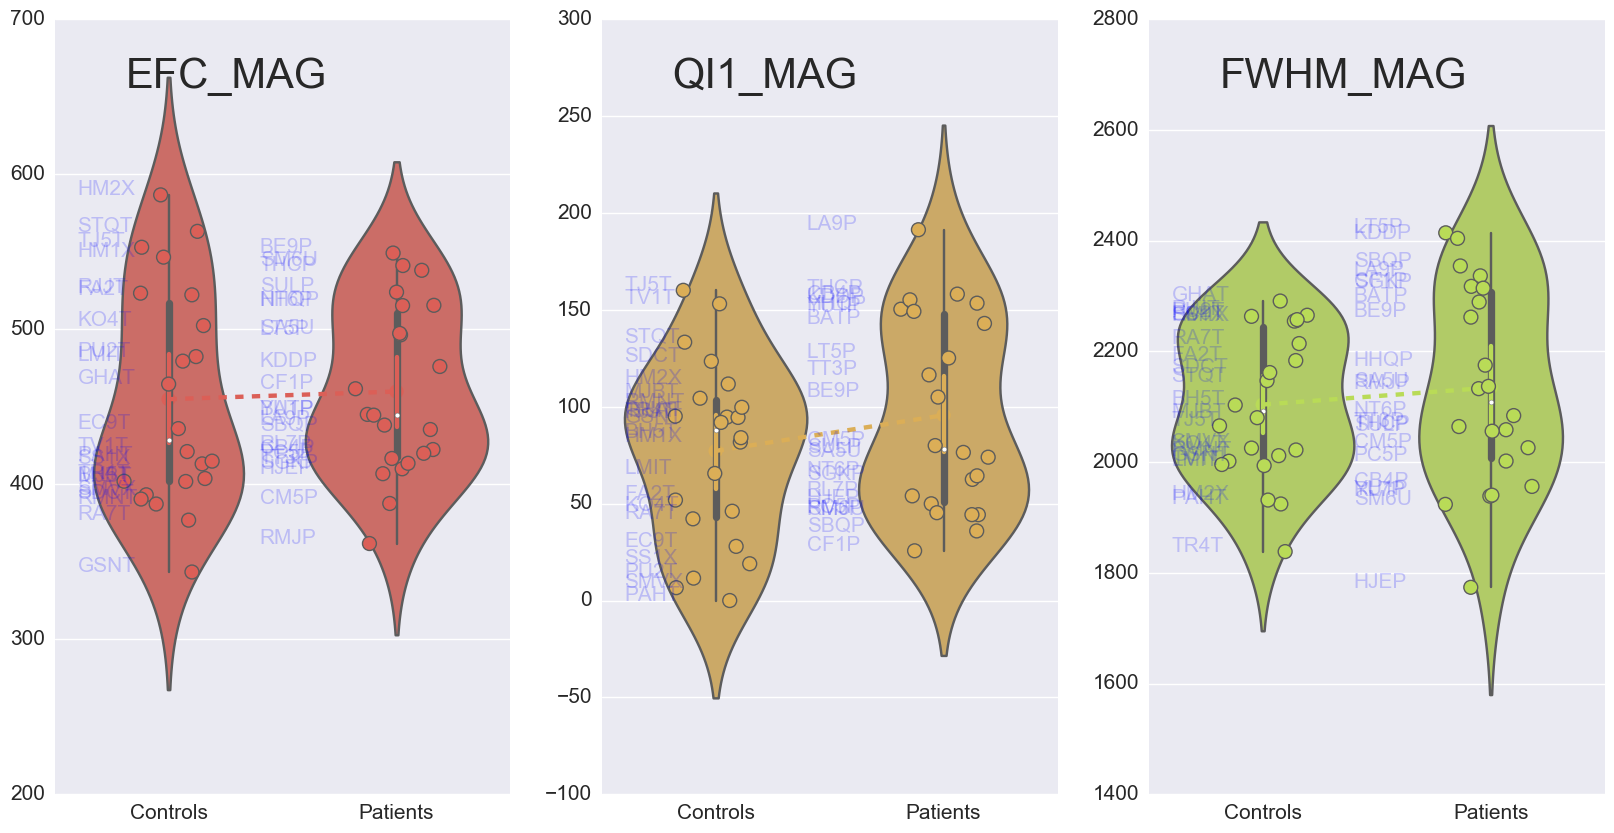

In [168]:
make_plot(controls_a,patients_a, m1 = 'EFC_MAG', m2 = 'QI1_MAG', m3 = 'FWHM_MAG', pal= [0,3])

In [28]:
len(DF_ALL)

46

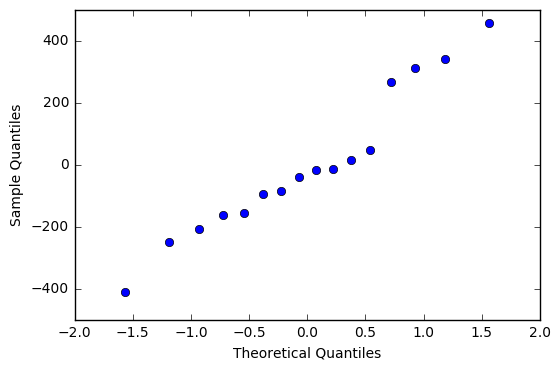

In [1]:
>>> import statsmodels.api as sm
>>> from matplotlib import pyplot as plt
>>> data = sm.datasets.longley.load()
>>> data.exog = sm.add_constant(data.exog)
>>> mod_fit = sm.OLS(data.endog, data.exog).fit()
>>> res = mod_fit.resid # residuals
>>> fig = sm.qqplot(res)
>>> plt.show()

In [77]:
stats.chi2(mahal_qc.Distance)

Skipping line 50: expected 4 fields, saw 6



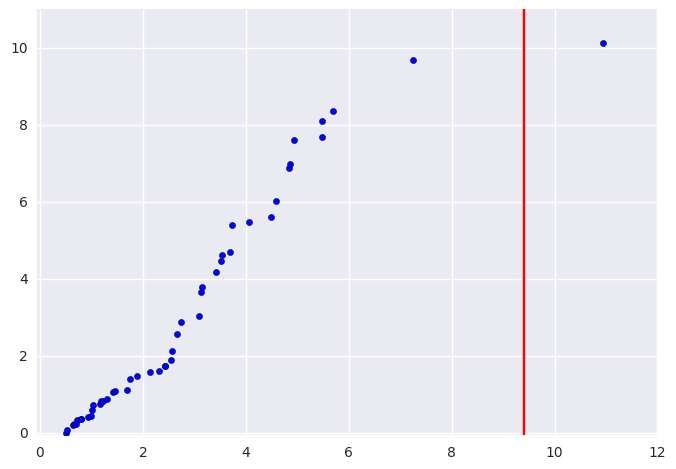

In [150]:
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
import os 
import statsmodels.api as sm
import scipy.stats as stats

tables_dir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Tables'
mahal_qc = pd.read_csv(os.path.join(tables_dir,'mahal_qc.txt'), delim_whitespace=True, error_bad_lines=False)

x   = mahal_qc.Distance
chi =  stats.chi2.pdf(x, 1)
plt.scatter(sorted(x),chi * 23)
plt.xlim(-.05,12)
plt.ylim(-.05,11)
plt.axvline(9.4, color='r', linestyle='-')
plt.show()


In [142]:
chi

array([ 0.00050766,  0.00393945,  0.0097284 ,  0.01097807,  0.01106278,
        0.01520977,  0.0159027 ,  0.0161833 ,  0.01872857,  0.02002879,
        0.02589018,  0.03209767,  0.03294426,  0.03627915,  0.03653615,
        0.03919389,  0.04634735,  0.04736671,  0.04863606,  0.06161977,
        0.06447095,  0.06865447,  0.07039545,  0.07556044,  0.07598811,
        0.08240218,  0.09326828,  0.11253174,  0.12581274,  0.13245339,
        0.15897647,  0.1647354 ,  0.18217761,  0.19465258,  0.2013411 ,
        0.20471287,  0.23463993,  0.23790899,  0.24391818,  0.26174736,
        0.29864749,  0.3030644 ,  0.33078006,  0.33358135,  0.35215154,
        0.363511  ,  0.42102835,  0.44005131])

In [143]:
9/0.421

21.37767220902613